In [1]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from utils import es as es
from utils import itd as itd
from utils import prob as prob
from tqdm import tqdm
import progressbar
import time
from scipy.signal import hilbert
from scipy.stats import pearsonr
from pprint import pprint
import pickle
import math
import sounddevice as sd
from beamforming import Beamformer
import IPython.display as ipd
import mir_eval
from numpy.linalg import LinAlgError as LinAlgError
from numpy.linalg import norm
from spectre import *
from librosa import stft, istft

# Initialise parameters

In [2]:
num_bins = 80
max_itd = 800e-6
num_channels = 64
relevant_channels = np.arange(0,20)

In [3]:
def get_timestamps_from_filename(filename):
    # IN: a filename
    # OUT: decoded data from that location with timestamps in seconds
    
    # load aedat data
    timestamps, addresses = es.loadaerdat(filename + '.aedat')
    print 'load data from ', filename
    
    timestamps = timestamps.astype('int64')
    discont = np.where(timestamps[:-1] - timestamps[1:] > 0)[0]
    print "Detected trigggers [{}]".format(len(discont))
    if len(discont) > 1:
        if discont[1] - discont[0] > 10000:
            addresses = addresses[:discont[-1]]
            timestamps = timestamps[:discont[-1]]
        
    index_trigger = discont[0] + 1
    addresses = addresses[index_trigger:]
    timestamps = timestamps[index_trigger:]
    
    
    
    # filter out weird timestamps before around 11000
#     index_weird_timestamps = np.where(timestamps>11000)[0][0]
#     addresses = addresses[index_weird_timestamps:]
#     timestamps = timestamps[index_weird_timestamps:]
    
    # filter out the second trigger at the end of the recording
#     if np.where(timestamps<5000)[0].size>0:
#         index_end_of_recording = np.where(timestamps<5000)[0][0]
#         addresses = addresses[:index_end_of_recording]
#         timestamps = timestamps[:index_end_of_recording]
    
    # decode events - side and neuron index --> timestamps are in seconds now
    timestamps, ear_id, type_id = es.decode_ams1c(timestamps, addresses, return_type=True)
    channel_id = type_id%64
    
    return timestamps, ear_id, type_id, channel_id

def calculate_itds(timestamps, ear_id, type_id, channel_id, return_itd_indices=True):
    print 'calculating itds'
    # filter for certain channels specified in relevant_channels
#     indices_channels = np.isin(channel_id, relevant_channels)
#     timestamps = timestamps[indices_channels]
#     ear_id = ear_id[indices_channels]
#     type_id = type_id[indices_channels]

    # calculate itds for the filtered timestamps
    itds, itd_indices = itd.get_itds(timestamps, ear_id, type_id, return_itd_indices=return_itd_indices)
    timestamps = timestamps[itd_indices]
    channel_id = channel_id[itd_indices]
    ear_id = ear_id[itd_indices]
    type_id = type_id[itd_indices]

    return timestamps, ear_id, type_id, channel_id, itds

def separate_dungeon_files(timestamps, sample):
    # IN: numpy array timestamps from a certain sample in seconds and char indicating which sample (A/B/C/D) it belongs to
    # OUT: array of the indices of timestamps where only the white speaker is active
    if sample == 'A':
        # for sample A this is the data for times between 0s and 15s
        return np.where(timestamps < 12.78125), \
               np.where(np.logical_and(timestamps >= 12.78125,timestamps < 26.5625)), \
               np.where(timestamps > 26.5625)
    
    elif sample == 'B':
        # for sample B this is the data for times between 15s and 30s
        return np.where(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), \
               np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_and(timestamps<12.78125,timestamps>=40.34375))
    elif sample == 'C':
        # for sample C this is the data for times between 0s and 15s
        return np.where(timestamps<12.78125), \
               np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_or(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), timestamps > 40.34375),
    elif sample == 'D':
        # for sample D this is the data for times between 30s and 45s
        return np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), \
               np.where(np.logical_and(timestamps<12.78125,timestamps>=40.34375))
    channel_id = channel_id[itd_indices]
    ear_id = ear_id[itd_indices]
    type_id = type_id[itd_indices]
    
    return timestamps, ear_id, type_id, channel_id, itds

def assign_the_spikes(itds, sigma=2):
    print 'applying hidden markov model'
    # hidden markov model
    index_angles = np.array([[0, -90], [1, -70], [2, -50], [3, -30], [4, -10], [5, 10], [6, 30], [7, 50], [8, 70], [9,90]])
    num_angles = len(priors)
    initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
    transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
    itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
    estimates, argmax_estimates = prob.get_estimates(itds, initial_estimate, transition_probabilities, itd_dict, priors)
    
    return estimates, argmax_estimates

def remove_trigger(signal):
    trigger_index = np.where(signal>20000)[0][-1]
    signal_trigger_removed = signal[trigger_index+1:]
    return signal_trigger_removed    


def specGramFast(x, win, overlap):
    x_ix = np.arange(0, x.shape[1] - len(win) + 1, overlap)
    x = x.astype('float32')
    s = np.zeros((x.shape[0], len(x_ix), int(len(win) / 2 + 1))).astype('complex64')
    for i in range(len(x_ix)):
        s[:, i, :] = np.fft.rfft(x[:, x_ix[i]:x_ix[i] + len(win)] * win)
    return s

def specGramFastL(x, frame_len, frame_step):
    s = np.array([stft(xx, frame_len, frame_step, window=np.hanning) for xx in x])
    return s

def estimate_fw_mapping(x1_spec):
        V, D, Rxx, LL = [], [], [], []

        for ii in range(x1_spec.shape[2]):  # Every frequency separately
            _R1 = x1_spec[:, :, ii].dot(np.conj(x1_spec[:, :, ii].T))
            Rxx.append(_R1)
            [_d, _v] = np.linalg.eig(_R1)
            idx = np.argsort(_d)[::-1]
            D.append(np.diag(_d[idx]))
            V.append(_v[:, idx])

        for v, d in zip(V, D):
            LL += [v[:, 0] * d[0, 0] / np.abs(d[0, 0])]

        return np.vstack(LL).T

def step_bf(x_spec, LL):
        x_spec.shape
        S = np.einsum('...ca,...cb', x_spec, np.conj(x_spec)) / x_spec.shape[1]

        Rzz = np.array(S)

        _C = LL
        W = np.zeros((Rzz.shape[0], x_spec.shape[2])).astype('complex64')

        for i, r, ll0 in (zip(range(Rzz.shape[0]), Rzz, _C.T)):
            invR = np.linalg.pinv(r)
            invRL0 = invR.dot(ll0)
            J0 = 1.0 / ll0.T.dot(np.conj(invRL0))
            weight0 = invRL0 * J0
            W[i, :] = weight0
        return W
    
def triggers(sample, fs, frame_step, jit=0, mode='last'):
    r = fs / frame_step
    t0 = 0 + jit
    t1 = int(12.78125 * r) + jit
    t2 = int(26.56250 * r) + jit
    t3 = int(40.34375 * r) + jit
    t4 = int(50.12500 * r) + jit
    if mode == 'last':
        if sample == 'A':
            return slice(t0, t1), slice(t1, t2), [slice(t3, t4)]

        elif sample == 'B':
            return slice(t1, t2), slice(t2, t3), [slice(t3, t4)]

        elif sample == 'C':
            return slice(t0, t1), slice(t2, t3), [slice(t3, t4)]

        elif sample == 'D':
            return slice(t2, t3), slice(t1, t2), [slice(t3, t4)]
        
    if mode == 'first':
        if sample == 'A':
            return slice(t0, t1), slice(t1, t2), [slice(t2, t3)]

        elif sample == 'B':
            return slice(t1, t2), slice(t2, t3), [slice(t0, t1)]

        elif sample == 'C':
            return slice(t0, t1), slice(t2, t3), [slice(t1, t2)]

        elif sample == 'D':
            return slice(t2, t3), slice(t1, t2), [slice(t0, t1)]
        
    if mode == 'both':
        if sample == 'A':
            return slice(t0, t1), slice(t1, t2), [slice(t2, t3), slice(t3, t4)]

        elif sample == 'B':
            return slice(t1, t2), slice(t2, t3), [slice(t0, t1), slice(t3, t4)]

        elif sample == 'C':
            return slice(t0, t1), slice(t2, t3), [slice(t1, t2), slice(t3, t4)]

        elif sample == 'D':
            return slice(t2, t3), slice(t1, t2), [slice(t0, t1), slice(t3, t4)]

def break_small(x, l=5):
    r = np.zeros_like(x)
    for i in range(len(x) - l):
        if np.sum(x[i:i+l]) == l:
            r[i:i+l] = 1
    return r


# Load the priors

In [4]:
filename_priors = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/priors_dungeon'
priors = np.load(filename_priors + '.npy')
itd_dict = itd.get_itd_dict(max_itd, num_bins)*1e6

In [5]:
prefix_filenames = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/dungeon_concurrent_'

pos = [1,8]  # [[10,1],[10,6],[1,8],[2,9],[3,9],[4,7],[6,5],[8,3],[9,7]]
sample = 'C'

# get all the filenames
filename_id = '%d_%d_%s' %(pos[0], pos[1], sample)
filename_cochlea = prefix_filenames + filename_id
filename_whisper1 = prefix_filenames + filename_id + '_1.wav'
filename_whisper3 = prefix_filenames + filename_id + '_3.wav'
filename_groundtruth1 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s1_T.wav' %sample
filename_groundtruth8 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s8_T.wav' %sample

In [6]:
# compute estimates
timestamps, ear_id, type_id, channel_id = get_timestamps_from_filename(filename_cochlea)
print len(timestamps)

timestamps, ear_id, type_id, channel_id, itds = calculate_itds( \
    timestamps, ear_id, type_id, channel_id, return_itd_indices=True)

estimates, argmax_estimates = assign_the_spikes(itds, sigma=45)



load data from  /Data/Dropbox/spike_separation_joy/recordings_dungeon/dungeon_concurrent_1_8_C
Detected trigggers [2]
667728
calculating itds
applying hidden markov model


228.5921658986175


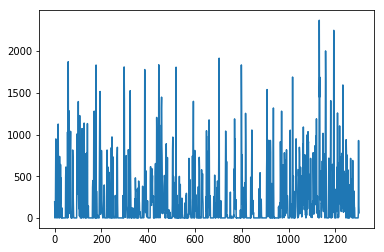

In [7]:
a = timestamps
frame_step_s = 1024.0 / 24000
ts = np.arange(0, np.max(a), frame_step_s)
c = [len(a[(a > t) & (a < (t + frame_step_s))]) for i, t in enumerate(ts)]

plt.plot(c)
print np.mean(c)

In [8]:
# ground truth
fs, groundtruth1 = wavfile.read(filename_groundtruth1)
groundtruth1 = remove_trigger(groundtruth1)
fs, groundtruth8 = wavfile.read(filename_groundtruth8)
groundtruth8 = remove_trigger(groundtruth8)

# params
fs = 24000.0
frame_len = 8192
frame_len_s = frame_len / fs
frame_step = 2048
frame_step_s = frame_step / fs
max_len = len(groundtruth1) / fs
JIT = int(frame_len / frame_step / 2)
print "JITTER is {}".format(JIT)


mag1 = stft(groundtruth1, frame_len, frame_step, window=np.hanning)
e1 = np.sum(np.log(np.abs(mag1) + 1), axis=0)
mag8 = stft(groundtruth8, frame_len, frame_step, window=np.hanning)
e8 = np.sum(np.log(np.abs(mag8) + 1), axis=0)
r_ch = range(10, 20)
# fig = plt.figure(figsize=(16,4))
scores = []
envs = []
for idx in tqdm(range(estimates.shape[1])):
#     a = timestamps[argmax_estimates==idx & np.array([k in r_ch for k in channel_id])]
    a = timestamps[argmax_estimates==idx]
    f_ch = channel_id[argmax_estimates==idx]
    summed_prob = np.sum(estimates[:, idx]) / len(timestamps)
    a = a[np.array([k in r_ch for k in f_ch])]
    ts = np.arange(0, frame_step_s * (len(e1) + 1), frame_step_s)
    c = [len(a[(a > t) & (a < (t + frame_len_s))]) for i, t in enumerate(ts[:-1])]
#         spks = a[(a > (t - frame_step_s)) & (a < t )]
#         probs = a_prob[(a > (t - frame_step_s)) & (a < t)]
#         c.append(np.sum(spks * probs))

    _score = summed_prob * len(a)
    scores.append(_score)
    envs.append(c)
    

JITTER is 2


100%|██████████| 10/10 [00:03<00:00,  3.68it/s]


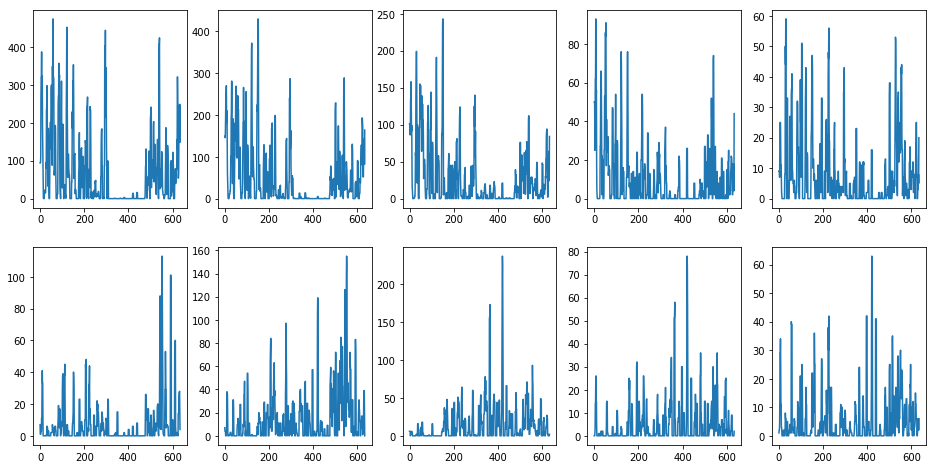

In [9]:
fig = plt.figure(figsize=(16,8))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.plot(envs[i])


Estimated [1, 8] == True [1, 8]
E1 = 7550.22452372 - E8 = 3402.66646133
Power ratio = 2.21891408092


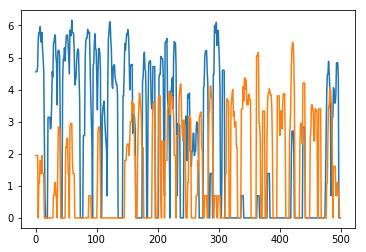

In [65]:
corr_envs = np.corrcoef(envs)
weights =  0.005 ** (corr_envs[np.argmax(scores)] + 1)

first = np.argmax(scores) + 1
second = np.argmax(np.log(scores * weights)) + 1

if first != second:
    print "Estimated [{}, {}] == True {}".format(first, second, pos)
else:
    third = np.argsort(np.log(scores * weights))[-2] + 1
    second = third
    print "Estimated [{}, {}] == True {}".format(first, third, pos)

# eliminated = envs[:]
# del eliminated[first - 1]
# del eliminated[second - 1]

# non_envs = np.mean(np.array(eliminated), axis=0)

estimated_env_1 = np.log(np.array(envs[first - 1]) + 1)
estimated_env_2 = np.log(np.array(envs[second - 1]) + 1)

plt.plot(estimated_env_1[:500])
plt.plot(estimated_env_2[:500])

# estimated_env_1 = np.log(np.clip(np.array(ccs[first - 1]) - non_envs, 0.0, np.inf) + 1)
# estimated_env_2 = np.log(np.clip(np.array(ccs[second - 1])  - non_envs, 0.0, np.inf) + 1)

# estimated_env_1 = estimated_env_1 / np.max(estimated_env_1)
# estimated_env_2 = estimated_env_2 / np.max(estimated_env_2)

E1 = np.sum(estimated_env_1 ** 2)
E2 = np.sum(estimated_env_2 ** 2)
p_ratio = E1 / E2
print "E1 = {} - E8 = {}".format(E1, E2)

print "Power ratio = {}".format(E1 / E2)

TH1 = TH2 = 0.9
vad1 = np.float32((estimated_env_1 - TH1 * estimated_env_1 > estimated_env_2))
vad2 = np.float32((estimated_env_2 - TH2 * estimated_env_2 > estimated_env_1))

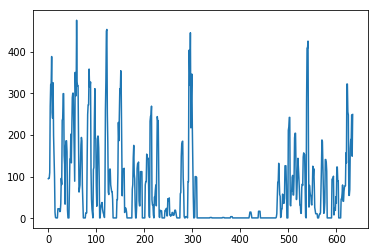

In [66]:
plt.plot(np.array(envs[first - 1]) + 1)

JITTER is 2
144943
PWR1 118.307330608 || PWR 2 118.677661419


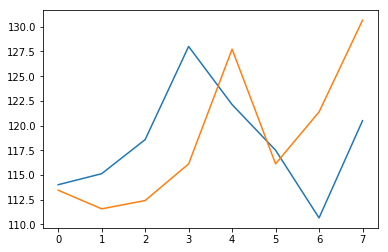

In [67]:
# # params
fs = 24000.0
frame_len = 2048
frame_len_s = frame_len / fs
frame_step = 512
frame_step_s = frame_step / fs
max_len = len(groundtruth1) / fs
JIT = int(frame_len / frame_step / 2)
print "JITTER is {}".format(JIT)
# load WHISPER data
# remove the trigger
fs, whisper1 = wavfile.read(filename_whisper1)
fs, whisper3 = wavfile.read(filename_whisper3)
# plt.plot(whisper1[:115000, 0])
# ipd.display(ipd.Audio(whisper1[:200000, 0], rate=fs))
TR = 10000 if sample in ['A', 'C'] and pos == [9, 7] else 18000
trigger_index = np.where(whisper1>TR)[0][0]
print trigger_index
# trigger_index = 115000
whisper1 = whisper1[trigger_index + int(fs / 32):].astype('float32')
whisper3 = whisper3[trigger_index + int(fs / 32):].astype('float32')

# make the same length
shortest_size = np.amin((whisper1.shape[0], whisper3.shape[0]))
whisper1_shortened = whisper1[:shortest_size,:]
whisper3_shortened = whisper3[:shortest_size,:]
whisper = np.concatenate((whisper1_shortened,whisper3_shortened),1)

# stfts & VADs
m2 = stft(groundtruth8, frame_len, frame_step, window=np.hanning).T
m1 = stft(groundtruth1, frame_len, frame_step, window=np.hanning).T
m1_sum = np.sum(np.log(np.abs(m1) + 1e-7), axis=-1)
m2_sum = np.sum(np.log(np.abs(m2) + 1e-7), axis=-1)
VAD1 = np.array(0.8 * m1_sum > m2_sum)
VAD2 = np.array(0.8 * m2_sum > m1_sum)

x_spec = np.transpose(specGramFastL(whisper.T, frame_len, frame_step), (0, 2, 1))

slice_spk1, slice_spk2, _ = triggers(sample, fs, 1)
spk1 = []
spk2 = []
for i in range(8):
    spk1 += [10 * np.log10(np.sum(whisper[slice_spk1, i] ** 2))]
    spk2 += [10 * np.log10(np.sum(whisper[slice_spk2, i] ** 2))]

plt.plot(spk1)
plt.plot(spk2)
print "PWR1 {} || PWR 2 {}".format(np.mean(spk1),np.mean(spk2))



In [68]:
R = int(np.floor(x_spec.shape[1] / len(vad1)))
vad1 = np.repeat(vad1, R)
vad2 = np.repeat(vad2, R)

VAD1 = VAD1[:min([len(vad1), len(VAD1)])]
VAD2 = VAD2[:min([len(vad2), len(VAD2)])]
vad1 = vad1[:min([len(vad1), len(VAD1)])]
vad2 = vad2[:min([len(vad2), len(VAD2)])]


m1_sum = np.sum(np.abs(m1), axis=-1)
m2_sum = np.sum(np.abs(m2), axis=-1)
m1 = m1_sum[::R]
m2 = m2_sum[::R]

e1 = np.array(envs[first - 1])
e1 = e1[:min([len(m1), len(e1)])].astype('float32')

e2 = np.array(envs[second - 1])
e2 = e2[:min([len(m2), len(e2)])].astype('float32')



In [69]:
print R

4


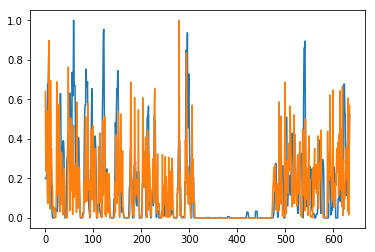

In [70]:
plt.plot(e1 / np.max(np.abs(e1)))
plt.plot(m1 / np.max(np.abs(m1)))

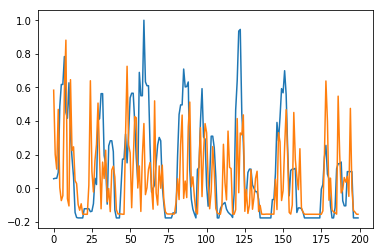

In [75]:
e1 -= np.mean(e1)
e1 /= np.min(np.abs(e1))
e2 -= np.mean(e2)
e2 /= np.min(np.abs(e2))

m1 -= np.mean(m1)
m1 /= np.min(np.abs(m1))
m2 -= np.mean(m2)
m2 /= np.min(np.abs(m2))


plt.plot(e1[:200] / np.max(np.abs(e1)))
plt.plot(m1[:200] / np.max(np.abs(m1)))

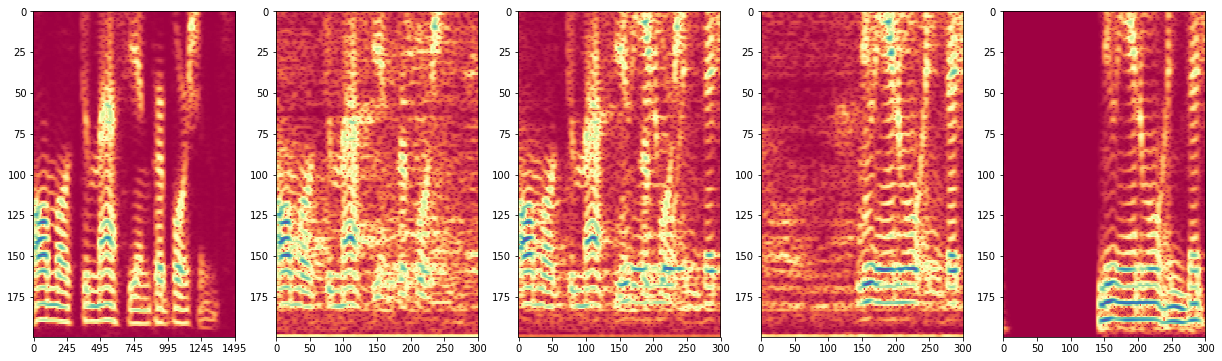

In [161]:
pos = [6,5]
sample = "A"

fs, eval1 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_1.wav'.format(pos[0], pos[1], sample))
fs, gt1 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_1_gt.wav'.format(pos[0], pos[1], sample))

fs, eval2 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_2.wav'.format(pos[0], pos[1], sample))
fs, gt2 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_2_gt.wav'.format(pos[0], pos[1], sample))

fs, whisper1 = wavfile.read(prefix_filenames + '{}_{}_{}_1.wav'.format(pos[0], pos[1], sample))
trigger_index = np.where(whisper1 > 18000)[0][0]
whisper1 = whisper1[trigger_index + int(fs / 32):].astype('float32')
w1 = whisper1[int(30 * fs):int(40 * fs), 0]
w1 /= np.max(np.abs(w1))

show_n_steps = 300
show_n_freq = 200
begin = 1400

win_length = 2048
hop_length = 128
t = np.arange(0, hop_length / fs, hop_length / fs * show_n_steps)
f = np.arange(0, fs / (int(win_length / 2) + 1), fs / (int(win_length / 2) + 1) * show_n_freq)


stft_eval1 = 20 * np.log10(np.abs(stft(eval1, win_length=win_length, hop_length=hop_length)) + 1)
stft_gt1 = 20 * np.log10(np.abs(stft(gt1, win_length=win_length, hop_length=hop_length)) + 1)
stft_w1 = 20 * np.log10(np.abs(stft(w1, win_length=win_length, hop_length=hop_length)) + 1)
stft_eval2 = 20 * np.log10(np.abs(stft(eval2, win_length=win_length, hop_length=hop_length)) + 1)
stft_gt2 = 20 * np.log10(np.abs(stft(gt2, win_length=win_length, hop_length=hop_length)) + 1)

cmap = 'Spectral'

fig = plt.figure(figsize=(21,6))
ax = fig.add_subplot(1,5,1)

ax.imshow(np.abs(stft_gt1[:show_n_freq, begin:begin + show_n_steps][::-1]),  aspect='auto', cmap=cmap)
ax.set_xticks([0, 49, 99, 149, 199, 249, 299])
ax.set_xticklabels(np.array([0, 49, 99, 149, 199, 249, 299]) * int(hop_length / 24))

ax = fig.add_subplot(1,5,2)
ax.imshow(np.abs(stft_eval1[:show_n_freq,begin:begin + show_n_steps][::-1]),  aspect='auto', cmap=cmap)

ax = fig.add_subplot(1,5,3)
ax.imshow(np.abs(stft_w1[:show_n_freq,begin:begin + show_n_steps][::-1]),  aspect='auto', cmap=cmap)

ax = fig.add_subplot(1,5,4)
ax.imshow(np.abs(stft_eval2[:show_n_freq,begin:begin + show_n_steps][::-1]),  aspect='auto', cmap=cmap)

ax = fig.add_subplot(1,5,5)
ax.imshow(np.abs(stft_gt2[:show_n_freq,begin:begin + show_n_steps][::-1]),  aspect='auto', cmap=cmap)





CORR: 0.4362 || 0.4795
Estimated JIT -2.0 || Theoretical JIT = 2
AFTER: 0.4303 || 0.4794


IndexError: too many indices for array

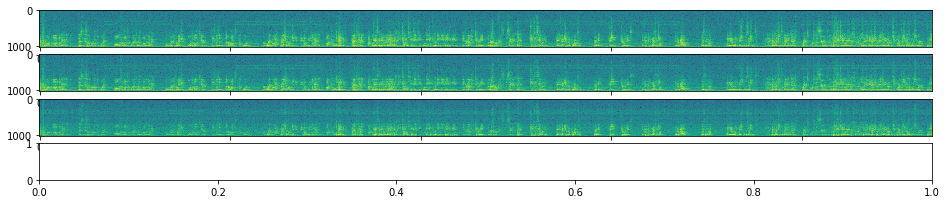

In [162]:
# solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(frame_len / 2 + 1)))
# solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(frame_len / 2 + 1)))
solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(frame_len / 2 + 1)))
solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(frame_len / 2 + 1)))

solid_vad11 = np.tile(np.expand_dims(break_small(vad1, 10), -1), (1, int(frame_len / 2 + 1)))
solid_vad22 = np.tile(np.expand_dims(break_small(vad2, 10), -1), (1, int(frame_len / 2 + 1)))

print "CORR: {:.4} || {:.4}".format(np.corrcoef(vad1, VAD1)[0,1], np.corrcoef(vad2, VAD2)[0,1])
mc1 = np.argmax(np.correlate(vad1, VAD1, "full")) - len(VAD1)
mc2 = np.argmax(np.correlate(vad2, VAD2, "full")) - len(VAD2)
print "Estimated JIT {} || Theoretical JIT = {}".format(np.mean([mc1, mc2]), JIT)
# JIT = int(np.mean([mc1, mc2])
print "AFTER: {:.4} || {:.4}".format(np.corrcoef(vad1[JIT:], VAD1[:-JIT])[0,1], np.corrcoef(vad2[JIT:], VAD2[:-JIT])[0,1])
# JIT = 140
# print solid_vad1.shape
lim0 = int(fs * 0 / frame_step)
lim1 = int(fs *50 / frame_step)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(10,1,1)
ax.imshow(np.log(np.abs(x_spec[0][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,2)
ax.imshow(np.log(np.abs(x_spec[1][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,3)
ax.imshow(np.log(np.abs(x_spec[6][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,4)
pos1 = np.abs(m1[lim0:lim1, ::-1]) 
neg1 = np.abs(m2[lim0:lim1, ::-1]) 
ax.imshow((np.log(pos1 + 1) - np.log(neg1 + 1)).T , aspect="auto")
ax = fig.add_subplot(10,1,5)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad1[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,6)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad11[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,7)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD1[lim0:lim1].T)
ax = fig.add_subplot(10,1,8)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad2[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,9)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad22[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,10)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD2[lim0:lim1].T)



In [ ]:
for i in range(8):
    ipd.display(ipd.Audio(whisper[:100000, i], rate=fs))


In [ ]:
# clean_ch = np.array([0,1,2,5,6,3])
# A1, B1 = 0, 13
# A2, B2 = 13, 26
# vad_slice1 = slice(int(fs * A1 / frame_step) + JIT, int(fs * B1 / frame_step) + JIT)
# spec_slice1 = slice(int(fs * A1 / frame_step), int(fs * B1 / frame_step))

# vad_slice2 = slice(int(fs * A2 / frame_step) + JIT, int(fs * B2 / frame_step) + JIT)
# spec_slice2 = slice(int(fs * A2 / frame_step), int(fs * B2 / frame_step))

# recons = []
# for vad, vad_slice, spec_slice in zip([vad1, vad2], [vad_slice1, vad_slice2], [spec_slice1, spec_slice2]):
#     x_speca = x_spec[clean_ch, :len(vad), :]
#     vad = np.expand_dims(np.expand_dims(vad,0), -1)
# #     LL1 = estimate_fw_mapping(x_speca[:, spec_slice] * vad[:, vad_slice])
#     LL1 = estimate_fw_mapping(x_speca[:, spec_slice] )
#     x_specb = x_speca.T
#     W = step_bf(x_specb, LL1)
#     recons.append(np.einsum('ab,acb->ca', np.conj(W), x_specb))

# recons[0] = istft(recons[0].T, frame_step, window=np.hanning)
# recons[1] = istft(recons[1].T, frame_step, window=np.hanning)
# print W.shape

In [ ]:
break_w = 200  # ms
break_w_int = int(np.ceil(break_w / 1000.0 * fs / frame_step))
print break_w_int
ch0 = np.array([0,1,2,5,6,3])
ch1 = np.array([0,1,2,5,6,3])

_, _, vad_slice = triggers(sample, fs, frame_step, JIT)
_, _, spec_slice = triggers(sample, fs, frame_step)
x_spec = x_spec[:, :len(vad1), :]

recons = []
for vad, ch in zip([vad1, vad2], [ch0, ch1]):
    # vad = vad[vad_slice]
    vad = np.expand_dims(np.expand_dims(break_small(vad, break_w_int), 0), -1)
    # vad = np.concatenate([vad[:, vad_slice[0]], vad[:, vad_slice[1]]], axis=1)
    xx = []
    for v_sl, x_sl in zip(vad_slice, spec_slice):
        xx += [x_spec[ch, x_sl] * vad[:, v_sl]]
    # x_spec_a = x_spec[:, spec_slice]
    # x_spec_a = x_spec_a[:, :vad.shape[1]]
    ll1 = estimate_fw_mapping(np.concatenate(xx, axis=1))
    x_spec_b = x_spec[ch].T
    w = step_bf(x_spec_b, ll1)
    recons.append(np.einsum('ab,acb->ca', np.conj(w), x_spec_b))

recons[0] = istft(recons[0].T, frame_step, window=np.hanning)
recons[1] = istft(recons[1].T, frame_step, window=np.hanning)


In [ ]:
# correct for filter length
init1 = 0
init0 = int(30 * fs) if sample == 'A' else int(16 * fs)
init2 = int(40 * fs) if sample == 'A' else int(26 * fs)
recons0 = recons[0][init0:init2]
recons1 = recons[1][init0:init2]
groundtruth11 = groundtruth1[init0:]
groundtruth88 = groundtruth8[init0:]

end = 100000

pp = np.correlate(recons1[init1:init1 + end], groundtruth88[init1:init1 + end], 'full')
j1 = np.argmax(pp) - end

pp = np.correlate(recons0[init1:init1 + end], groundtruth11[init1:init1 + end], 'full')
j0 = np.argmax(pp) - end

print "{} || {}".format(j0, j1)

if j0 > 0:
    recons0 = recons0[j0:]
else:
    groundtruth11 = groundtruth11[abs(j0):]
        
if j1 > 0:
    recons1 = recons1[j1:]
else:
    groundtruth88 = groundtruth88[abs(j1):]
min_len = np.min([len(recons0), len(recons1), len(groundtruth11), len(groundtruth88)])
recons0 = recons0[:min_len]
recons1 = recons1[:min_len]
groundtruth11 = groundtruth11[:min_len]
groundtruth88 = groundtruth88[:min_len]

# fig = plt.figure(figsize=(16,2))
# ax = fig.add_subplot(1,2,1)
# ax.plot(recons0 / np.max(abs(recons0)))
# ax.plot(groundtruth11 / np.max(np.abs(groundtruth11)))
# # ax.plot(whisper[:, 0] / np.max(np.abs(whisper[:, 0])))
# ax = fig.add_subplot(1,2,2)
# ax.plot(recons1 / np.max(abs(recons1)))
# ax.plot(groundtruth88 / np.max(np.abs(groundtruth88)))

ipd.display(ipd.Audio(recons0[:200000], rate=fs))
ipd.display(ipd.Audio(recons1[:200000], rate=fs))
ipd.display(ipd.Audio(groundtruth11[:200000], rate=fs))
ipd.display(ipd.Audio(groundtruth88[:200000], rate=fs))
sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(np.array([groundtruth11, groundtruth88]), np.array([recons0, recons1]))
print "SIR {}".format(sir)
print sdr

In [ ]:
# other
sample = 'C'
CH = 0
fs = 24000
pos = [6,5]

for CH in [0,1,2,3]:
    for W in [1,3]:
        init1 = 0
        init0 = int(30 * fs) if sample == 'A' else int(16 * fs)
        init2 = int(40 * fs) if sample == 'A' else int(26 * fs)

        s2 = 'B' if sample == 'A' else 'A'
        TR = 10000 if s2 in ['A', 'C'] and pos == [9, 7] else 18000
        filename_id = '%d_%d_%s' %(pos[0], pos[1], s2)
        filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(W)
        fs, whisper1 = wavfile.read(filename_whisper1)
        trigger_index = np.where(whisper1>TR)[0][0]
        whisperB = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

        s3 = 'D' if sample == 'A' else 'B'
        TR = 10000 if s3 in ['A', 'C'] and pos == [9, 7] else 18000
        filename_id = '%d_%d_%s' %(pos[0], pos[1], s3)
        filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(W)
        fs, whisper1 = wavfile.read(filename_whisper1)
        trigger_index = np.where(whisper1>TR)[0][0]
        whisperC = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

#         print len(whisperC)

        whisperB = whisperB[init0:init2]
        whisperC = whisperC[init0:init2]

        filename_groundtruth1 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s1_T.wav' %sample
        filename_groundtruth8 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s8_T.wav' %sample
        # ground truth
        fs, groundtruth1 = wavfile.read(filename_groundtruth1)
        groundtruth1 = remove_trigger(groundtruth1)
        fs, groundtruth8 = wavfile.read(filename_groundtruth8)
        groundtruth8 = remove_trigger(groundtruth8)
        groundtruth11 = groundtruth1[init0:init2]
        groundtruth88 = groundtruth8[init0:init2]

        # plt.plot(groundtruth11)
        # plt.plot(whisperC)
        # plt.figure()
        # plt.plot(groundtruth88)
        # plt.plot(whisperB)


        end = 100000

        pp = np.correlate(whisperB[init1:init1 + end], groundtruth88[init1:init1 + end], 'full')
        j1 = np.argmax(pp) - end

        pp = np.correlate(whisperC[init1:init1 + end], groundtruth11[init1:init1 + end], 'full')
        j0 = np.argmax(pp) - end

#         print "{} || {}".format(j0, j1)

        if j0 > 0:
            whisperC = whisperC[j0:]
        else:
            groundtruth11 = groundtruth11[abs(j0):]

        if j1 > 0:
            whisperB = whisperB[j1:]
        else:
            groundtruth88 = groundtruth88[abs(j1):]

        min_len = np.min([len(whisperB), len(whisperC), len(groundtruth11), len(groundtruth88)])
        whisperB = whisperB[:min_len]
        whisperC = whisperC[:min_len]
        groundtruth11 = groundtruth11[:min_len]
        groundtruth88 = groundtruth88[:min_len]

        plt.plot(groundtruth88 * 2)
        plt.plot(whisperB)
        plt.figure()
        plt.plot(groundtruth11 * 2)
        plt.plot(whisperC)

        sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(np.array([groundtruth11, groundtruth88]), np.array([whisperC, whisperB]))
        print "{} - {}: SIR {} || SAR {} || SDR {}".format(CH, W, sir, sar, sdr)


In [ ]:
to_save = []
save_name = 'best'
with open('baseline_best_3.csv', 'w') as results:
    results.write(
            'Conf0,Conf1,Type,SIR1,SIR2,SDR1,SDR2,SAR1,SAR2\n')
    for pos in [[10, 1], [10, 6], [1, 8], [2, 9], [3, 9], [4, 7], [6, 5], [8, 3], [9, 7]]:
        for sample in ['A', 'C']:
            SIR = []
            SDR = []
            SAR = []
            for CH in [0, 1, 2, 3]:
                for W in [1, 3]:
                    init1 = 0
                    init0 = int(30 * fs) if sample == 'A' else int(16 * fs)
                    init2 = int(40 * fs) if sample == 'A' else int(26 * fs)

                    s2 = 'B' if sample == 'A' else 'A'
                    TR = 10000 if s2 in ['A', 'C'] and pos == [9, 7] else 18000
                    filename_id = '%d_%d_%s' % (pos[0], pos[1], s2)
                    filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(W)
                    fs, whisper1 = wavfile.read(filename_whisper1)
                    trigger_index = np.where(whisper1 > TR)[0][0]
                    whisperB = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

                    s3 = 'D' if sample == 'A' else 'B'
                    TR = 10000 if s3 in ['A', 'C'] and pos == [9, 7] else 18000
                    filename_id = '%d_%d_%s' % (pos[0], pos[1], s3)
                    filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(W)
                    fs, whisper1 = wavfile.read(filename_whisper1)
                    trigger_index = np.where(whisper1 > TR)[0][0]
                    whisperC = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

                    whisperB = whisperB[init0:init2]
                    whisperC = whisperC[init0:init2]
                    
                    filename_groundtruth1 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s1_T.wav' % sample
                    filename_groundtruth8 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s8_T.wav' % sample
                    # ground truth
                    fs, groundtruth1 = wavfile.read(filename_groundtruth1)
                    groundtruth1 = remove_trigger(groundtruth1)
                    fs, groundtruth8 = wavfile.read(filename_groundtruth8)
                    groundtruth8 = remove_trigger(groundtruth8)

                    groundtruth11 = groundtruth1[init0:init2]
                    groundtruth88 = groundtruth8[init0:init2]

                    end = 100000

                    pp = np.correlate(whisperB[init1:init1 + end], groundtruth88[init1:init1 + end], 'full')
                    j1 = np.argmax(pp) - end

                    pp = np.correlate(whisperC[init1:init1 + end], groundtruth11[init1:init1 + end], 'full')
                    j0 = np.argmax(pp) - end

                    if j0 > 0:
                        whisperC = whisperC[j0:]
                    else:
                        groundtruth11 = groundtruth11[abs(j0):]

                    if j1 > 0:
                        whisperB = whisperB[j1:]
                    else:
                        groundtruth88 = groundtruth88[abs(j1):]

                    min_len = np.min([len(whisperB), len(whisperC), len(groundtruth11), len(groundtruth88)])
                    whisperB = whisperB[:min_len]
                    whisperC = whisperC[:min_len]
                    groundtruth11 = groundtruth11[:min_len]
                    groundtruth88 = groundtruth88[:min_len]

                    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(np.array([groundtruth11, groundtruth88]),
                                                                               np.array([whisperC, whisperB]))

                    SIR.append(sir)
                    SAR.append(sar)
                    SDR.append(sdr)
                    
                    to_save.append({'wC': whisperC, 'wB': whisperB, 'gt1': groundtruth11, 'gt8': groundtruth88})
                    
            sir_b = np.max(np.array(SIR), axis=0)
            sar_b = np.max(np.array(SAR), axis=0)
            sdr_b = np.max(np.array(SDR), axis=0)
            
            idxs_save = np.argmax(np.array(SDR), axis=0)
            
            recons0 = to_save[idxs_save[0]]['wC']
            recons1 = to_save[idxs_save[1]]['wB']
            groundtruth11 = to_save[idxs_save[0]]['gt1']
            groundtruth88 = to_save[idxs_save[1]]['gt8']
            
            wavfile.write('output_wavs/{}_{}_{}_1.wav'.format(save_name, pos, sample), fs,
                          recons0 / np.max(np.abs(recons0)))
            wavfile.write('output_wavs/{}_{}_{}_2.wav'.format(save_name, pos, sample), fs,
                          recons1 / np.max(np.abs(recons1)))
            wavfile.write('output_wavs/{}_{}_{}_1_gt.wav'.format(save_name, pos, sample), fs,
                          groundtruth11 / np.max(np.abs(groundtruth11)))
            wavfile.write('output_wavs/{}_{}_{}_2_gt.wav'.format(save_name, pos, sample), fs,
                          groundtruth88 / np.max(np.abs(groundtruth88)))
            
            print "{} - {}: SIR {} || SAR {} || SDR {}".format(pos, sample, sir_b, sar_b, sdr_b)
            results.write(
                    '{},{},{},{},{},{},{},{},{}\n'.format(pos[0], pos[1], sample, sir_b[0], sir_b[1], 
                                                           sdr_b[0], sdr_b[1], sar_b[0], sar_b[1]))


In [ ]:
for WH in [1,3]:
    for CH in [0,1,2,3]:
        # other
        s2 = 'B' if sample == 'A' else 'A'
        TR = 10000 if s2 in ['A', 'C'] and pos == [9, 7] else 18000
        filename_id = '%d_%d_%s' %(pos[0], pos[1], s2)
        filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(WH)
        fs, whisper1 = wavfile.read(filename_whisper1)
        trigger_index = np.where(whisper1>TR)[0][0]
        whisperB = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

        s3 = 'D' if sample =='A' else 'B'
        TR = 10000 if s3 in ['A', 'C'] and pos == [9, 7] else 18000
        filename_id = '%d_%d_%s' %(pos[0], pos[1], s3)
        filename_whisper1 = prefix_filenames + filename_id + '_{}.wav'.format(WH)
        fs, whisper1 = wavfile.read(filename_whisper1)
        trigger_index = np.where(whisper1>TR)[0][0]
        whisperC = whisper1[trigger_index + int(fs / 32):, CH].astype('float32')

        whisperB = whisperB[init0:init2]
        whisperC = whisperC[init0:init2]

#         ipd.display(ipd.Audio(whisperB, rate=fs))
#         ipd.display(ipd.Audio(whisperC, rate=fs))

        recons0 = recons[0][init0:init2]
        recons1 = recons[1][init0:init2]

        whisperCC = whisperC
        whisperBB = whisperB
        end = 100000

        pp = np.correlate(recons1[init1:init1 + end], whisperB[init1:init1 + end], 'full')
        j1 = np.argmax(pp) - end

        pp = np.correlate(recons0[init1:init1 + end], whisperC[init1:init1 + end], 'full')
        j0 = np.argmax(pp) - end

#         print "{} || {}".format(j0, j1)

        if j0 > 0:
            recons0 = recons0[j0:]
        else:
            whisperCC = whisperCC[abs(j0):]

        if j1 > 0:
            recons1 = recons1[j1:]
        else:
            whisperBB = whisperBB[abs(j1):]

        min_len = np.min([len(recons0), len(recons1), len(whisperBB), len(whisperCC)])
        recons0 = recons0[:min_len]
        recons1 = recons1[:min_len]
        whisperCC = whisperCC[:min_len]
        whisperBB = whisperBB[:min_len]

        wavfile.write('/Data/software/PEASS-Software-v2.0.1/example/dPEASS_{}_{}_1.wav'.format(pos, sample), fs,
                                          recons0 / np.max(np.abs(recons0)))
        wavfile.write('/Data/software/PEASS-Software-v2.0.1/example/dPEASS_{}_{}_2.wav'.format(pos, sample), fs,
                      recons1 / np.max(np.abs(recons1)))
        wavfile.write('/Data/software/PEASS-Software-v2.0.1/example/dPEASS_{}_{}_1_gt.wav'.format(pos, sample), fs,
                      whisperCC / np.max(np.abs(whisperCC)))
        wavfile.write('/Data/software/PEASS-Software-v2.0.1/example/dPEASS_{}_{}_2_gt.wav'.format(pos, sample), fs,
                      whisperBB / np.max(np.abs(whisperBB)))



        sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(np.array([whisperCC, whisperBB]), np.array([recons0, recons1]))
        print "{} {}: {} {} {} {}".format(WH, CH, sdr, sir, sar, perm)

In [ ]:
import pandas as pd
from tabulate import tabulate

# for mode in ['GCC', 'MNICA', 'SO']:
for mode in ['MNICA']:
    df = pd.read_csv('test__final__{}.csv'.format(mode))

    _sir = list(df['SIR1']) + list(df['SIR2'])
    SIR_m, SIR_s = np.mean(_sir), np.std(_sir)
    _sir_gt = list(df['GTSIR1']) + list(df['GTSIR2'])
    SIR_gt_m, SIR_gt_s = np.mean(_sir_gt), np.std(_sir_gt)
    _sir_best = list(df['BESTSIR1']) + list(df['BESTSIR2'])
    SIR_best_m, SIR_best_s = np.mean(_sir_best), np.std(_sir_best)

    _sdr = list(df['SDR1']) + list(df['SDR2'])
    SDR_m, SDR_s = np.mean(_sdr), np.std(_sdr)
    _sdr_gt = list(df['GTSDR1']) + list(df['GTSDR2'])
    SDR_gt_m, SDR_gt_s = np.mean(_sdr_gt), np.std(_sdr_gt)
    _sdr_best = list(df['BESTSDR1']) + list(df['BESTSDR2'])
    SDR_best_m, SDR_best_s = np.mean(_sdr_best), np.std(_sdr_best)

    _sar = list(df['SAR1']) + list(df['SAR2'])
    SAR_m, SAR_s = np.mean(_sar), np.std(_sar)
    _sar_gt = list(df['GTSAR1']) + list(df['GTSAR2'])
    SAR_gt_m, SAR_gt_s = np.mean(_sar_gt), np.std(_sar_gt)
    _sar_best = list(df['BESTSAR1']) + list(df['BESTSAR2'])
    SAR_best_m, SAR_best_s = np.mean(_sar_best), np.std(_sar_best)

    df = pd.read_csv('eval_stoi_{}sad.csv'.format(mode))

    _stoi = list(df['stoi1']) + list(df['stoi2'])
    STOI_m, STOI_s = np.mean(_stoi), np.std(_stoi)
    _stoi_gt = list(df['gtstoi1']) + list(df['gtstoi2'])
    STOI_gt_m, STOI_gt_s = np.mean(_stoi_gt), np.std(_stoi_gt)
    STOI_best_m = df['gtstoi2'][0]
    
    ## PEASS
    df = pd.read_csv('eval_PEASS_{}sad.csv'.format(mode))
    _ops = list(df['OPS1']) + list(df['OPS2'])
    OPS_m, OPS_s = np.mean(_ops), np.std(_ops)
    _ops_gt = list(df['gtOPS1']) + list(df['gtOPS2'])
    OPS_gt_m, OPS_gt_s = np.mean(_ops_gt), np.std(_ops_gt)
    
    _oas = list(df['OAS1']) + list(df['OAS2'])
    OAS_m, OAS_s = np.mean(_oas), np.std(_oas)
    _oas_gt = list(df['gtOAS1']) + list(df['gtOAS2'])
    OAS_gt_m, OAS_gt_s = np.mean(_oas_gt), np.std(_oas_gt)
    

    headers = ["{}".format(mode), "EVAL", "W/ GT", "BEST"]
    table = [["SIR", SIR_m, SIR_gt_m, SIR_best_m],
             ["SAR", SAR_m, SAR_gt_m, SAR_best_m],
             ["SDR", SDR_m, SDR_gt_m, SDR_best_m],
             ["STOI", STOI_m, STOI_gt_m, STOI_best_m],
             ["PEASS - OTS", OPS_m, OPS_gt_m, 0.0],
             ["PEASS - ATS", OPS_m, OPS_gt_m, 0.0]]

    print tabulate(table, headers, tablefmt="fancy_grid")

# a = np.where(np.logical_and(np.logical_and(df['Conf1'] == 7,df['Conf0'] == 9), df['Type'] == 'A'))[0][0]
# print a

In [ ]:
df = pd.read_csv('test__final__{}.csv'.format(mode))
x = df['SNR']
y = df['SIR1']
x_idx = np.argsort(x)
x = np.sort(x)
plt.plot(x, y[x_idx])